In [2]:
# 导入库

#数据处理
import numpy as np 
import pandas as pd #数据计算与处理
import re   #用于字符串的匹配，调用方法

#自然语言处理工具
import nltk  
from nltk.corpus import stopwords 
from nltk.stem.porter import PorterStemmer #词干提取
from collections import Counter  #统计频数

#可视化工具
import seaborn as sns 
import matplotlib.pyplot as plt  
import cufflinks as cf  
cf.go_offline() #如果使用online模式，那么生成的图形是有限制的，我们这里先设置为offline模式，这样就避免了出现次数限制问题。
from wordcloud import WordCloud, STOPWORDS  #词云图
from IPython.core.display import display, HTML  #显示功能
import plotly.graph_objects as go  

#建模相关
from tensorflow.keras.preprocessing.text import Tokenizer  #分词器
from tensorflow.keras.preprocessing.sequence import pad_sequences   #序列与处理
import tensorflow as tf      #机器学习库
from tqdm import tqdm

In [3]:
#加载数据

train = pd.read_csv("D:/机器学习/NLP/nlp-getting-started/train.csv")
test = pd.read_csv("D:/机器学习/NLP/nlp-getting-started/test.csv")
submission =  pd.read_csv("D:/机器学习/NLP/nlp-getting-started/sample_submission.csv")

In [3]:
train.head()   #查看训练集样本

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


id：每条推文的唯一标识符
text：推文的内容
location：发送推文的位置（可以为空白）
keyword：推文中的关键字（可以为空白）
target：仅在train.csv中，表示一条推文描述的灾难是否真实，真实为（1）或虚假为（0）

In [4]:
test.head()    #查看测试集样本

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


此处无target列

In [5]:
#数据可视化

#绘制真实虚假灾难数量对比的饼图
counts_train = train.target.value_counts(sort=False) #查看target列中有多少个不同值并计算每个不同值有在该列中有多少重复值
labels = counts_train.index   
values_train = counts_train.values 

data = go.Pie(labels=labels, values=values_train ,pull=[0.03, 0])                  #输入饼图数据
layout = go.Layout(title='Comparing Tweet is a real disaster (1) or not (0) in %') #设置标题

fig = go.Figure(data=[data], layout=layout)                                        #绘制饼图
fig.update_traces(hole=.3, hoverinfo="label+percent+value")                        #设置饼图的显示，标签，百分比，值
fig.update_layout(annotations=                                                     #在饼图的中心添加注释
                  [dict(text='Train', x=0.5, y=0.5, font_size=20, showarrow=False)])
fig.show()                                                                         #显示饼图

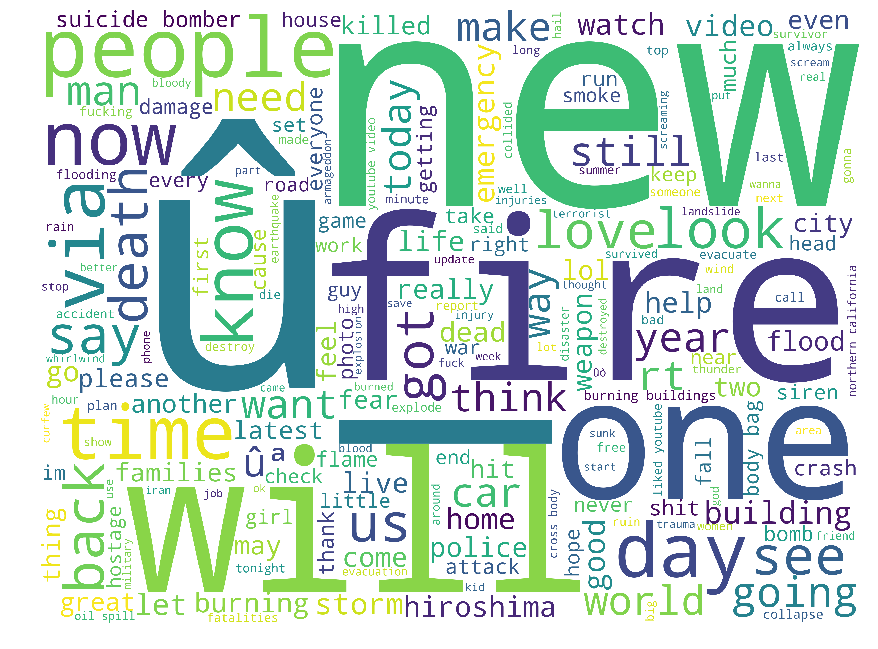

In [6]:
#绘制推文内容的词云
STOPWORDS.add('https')  #将https加入停用词表
STOPWORDS.add('co')
STOPWORDS.add('amp')
#定义函数：绘制词云图
def Plot_world(text):
    
    comment_words = ' '
    stopwords = set(STOPWORDS)    #创建停用词元素集
    
    for val in text:    #遍历text中的值
        val = str(val)  #将每个值转换成字符串
        tokens = val.split()    #分割值

        for i in range(len(tokens)):    
            tokens[i] = tokens[i].lower()   #遍历分割后的字符串，并将每个词转换成小写

        for words in tokens: 
            comment_words = comment_words + words + ' '   #遍历字符串中的所有词,将每个词用空格隔开


    wordcloud = WordCloud(width = 4000, height = 3000,    #生成词云
                    background_color ='white', 
                    stopwords = stopwords, 
                    min_font_size = 10).generate(comment_words) 

    #绘制词云                        
    plt.figure(figsize = (12, 12), facecolor = 'white', edgecolor = 'white' ) 
    plt.imshow(wordcloud) 
    plt.axis("off")            #不显示坐标轴
    plt.tight_layout(pad = 0)  #图像自动调整，设置间距
 
    plt.show() 
    wordcloud.to_file('wordcloud.png')
#运行函数    
text = train.text.values
Plot_world(text)

In [7]:
#数据清洗

#删除网址
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

In [8]:
train['text']=train['text'].apply(lambda x : remove_URL(x))

In [9]:
#删除HTML标签
def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)

In [10]:
train['text']=train['text'].apply(lambda x : remove_html(x))

In [11]:
#删除表情
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

In [12]:
train['text']=train['text'].apply(lambda x: remove_emoji(x))

In [13]:
#删除标点符号
import string
def remove_punct(text):
    table=str.maketrans('','',string.punctuation)
    return text.translate(table)

In [14]:
train['text']=train['text'].apply(lambda x : remove_punct(x))

In [ ]:
#拼写校正（速度慢）
from spellchecker import SpellChecker
spell = SpellChecker()
def correct_spellings(text):
    corrected_text = []
    misspelled_words = spell.unknown(text.split())
    for word in text.split():
        if word in misspelled_words:
            corrected_text.append(spell.correction(word))
        else:
            corrected_text.append(word)
    return " ".join(corrected_text)

In [ ]:
train['text']=train['text'].apply(lambda x : correct_spellings(x))

In [ ]:
#将清洗后的数据保存
train.to_csv('clean_train.csv')

In [4]:
#重新载入数据
train = pd.read_csv('clean_train.csv')

In [5]:
#文本序列化
 
from tensorflow.keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer()              #分词器
tokenizer.fit_on_texts(train.text)   #用本文内容学习字典
word_index = tokenizer.word_index    #将词映射为索引值
print('Number of unique words:',len(word_index))


Number of unique words: 14666


In [6]:
training_sequences = tokenizer.texts_to_sequences(train.text)  #将训练集的文本转化为序列
MAX_LEN=20
training_padded = pad_sequences(training_sequences,      #填充序列
                                maxlen=MAX_LEN,          #设置序列长度
                                padding='post',          #需要补充时确定补0的位置 结尾
                                truncating='post')       #需要截断时确定截断位置  结尾

In [7]:
#嵌入glove字典
embedding_dict={}
with open('D:/机器学习/NLP/IMDB/glove.6B.100d.txt','r',encoding='utf-8') as f:
    for line in f:
        values=line.split()
        word=values[0]
        vectors=np.asarray(values[1:],'float32')
        embedding_dict[word]=vectors
f.close()

In [8]:
#匹配GloVe向量
num_words=len(word_index)+1
embedding_dim=100
embedding_matrix = np.zeros((num_words, embedding_dim))
for word, i in tqdm(word_index.items()):
    if i < num_words:
        #返回glove字典中相应的word对应的词向量
        embedding_vector = embedding_dict.get(word)  
        if embedding_vector is not None:
        #在嵌入索引中找不到的单词将为全零。
            embedding_matrix[i] = embedding_vector

embedding_matrix.shape

100%|████████████████████████████████████████████████████████████████████████| 14666/14666 [00:00<00:00, 667842.78it/s]


(14667, 100)

In [9]:
#建立模型
from keras.models import Sequential 
from keras.layers import Embedding,Dense,Dropout,LSTM
from keras import optimizers,initializers

def create_model():
    model = Sequential() 
                        #input_dim即词汇量，输入数组中的词典大小是14666，即有14666个不同的词，所以我的input_dim便要比14666要大1，
    model.add(Embedding(input_dim=num_words,
                        #output_dim是密集嵌入的尺寸，就如同CNN最后的全连接层一样，上面设置的100，便将每一个词变为用1x100来表示的向量，
                        output_dim=100,
                        #嵌入矩阵的初始化的方法，为预定义初始化方法名的字符串，或用于初始化权重的初始化器。
                        embeddings_initializer=initializers.Constant(embedding_matrix), 
                        #输入序列的长度为20，本层将每个text表示为一个20×100的矩阵
                        input_length=MAX_LEN,trainable=False))
    #正则化，防止过拟合
    model.add(Dropout(0.2))    
    #LSTM层，长短期记忆
    model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
    #全连接层
    model.add(Dense(1, activation='sigmoid')) 
    #编译模型
    model.compile(loss='binary_crossentropy',  #一般搭配sigmoid
                  optimizer='adam',            #优化器
                  metrics=['accuracy'])        #模型评估标准
    return model

#模型摘要
model=create_model()
model.summary()

Using TensorFlow backend.





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 20, 100)           1466700   
_________________________________________________________________
dropout_1 (Dropout)          (None, 20, 100)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                42240     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 1,509,005
Trainable params: 42,305
Non-trainable params: 1,466,700
_________________________________________________________________


In [10]:
#参数选择与调优———网格搜索和交叉验证
#Scikit-Learn里有一个API 为model.selection.GridSearchCV，可以将keras搭建的模型传入，作为sklearn工作流程一部分。
from keras.wrappers.scikit_learn import KerasClassifier 
from sklearn.model_selection import GridSearchCV 
#包装keras模型以便在scikit-learn中使用keras，该模型用作scikit-learn中的estimator
model = KerasClassifier(build_fn=create_model, verbose=0) 
#定义网格搜索超参数
batch_size = [5, 10, 50, 100] 
epochs = [5, 10, 20, 50] 
#参数字典
param_grid = dict(batch_size=batch_size, nb_epoch=epochs)
#网格搜索，5折交叉验证
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=1) 

In [11]:
#训练获得最优模型
grid_result = grid.fit(training_padded, train['target'].values) 

In [12]:
#查看训练结果信息
results= pd.DataFrame(grid_result.cv_results_)
results.head(16)

D:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning:

You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True

D:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning:

You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True

D:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning:

You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True

D:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning:

You are accessing a training score ('split3_train_score'), which will not be availabl

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_batch_size,param_nb_epoch,params,split0_test_score,split1_test_score,split2_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,11.866801,0.571173,0.714815,0.085923,5,5,"{'batch_size': 5, 'nb_epoch': 5}",0.814839,0.786605,0.748523,...,0.782871,0.021792,12,0.802299,0.807225,0.804926,0.798555,0.795764,0.801754,0.004157
1,11.909189,0.399533,0.987507,0.079711,5,10,"{'batch_size': 5, 'nb_epoch': 10}",0.811556,0.780696,0.782666,...,0.789045,0.014340,4,0.805090,0.804105,0.815928,0.807749,0.798884,0.806351,0.005587
2,13.456750,0.533441,1.333631,0.095626,5,20,"{'batch_size': 5, 'nb_epoch': 20}",0.812213,0.781353,0.748523,...,0.783528,0.023521,11,0.810181,0.811002,0.813793,0.807913,0.787391,0.806056,0.009520
3,15.493069,0.501098,1.767592,0.114396,5,50,"{'batch_size': 5, 'nb_epoch': 50}",0.804990,0.755745,0.747866,...,0.777355,0.023481,15,0.806240,0.808374,0.809852,0.807421,0.805615,0.807500,0.001513
4,12.092622,0.880719,2.051300,0.164088,10,5,"{'batch_size': 10, 'nb_epoch': 5}",0.811556,0.748523,0.733421,...,0.774071,0.031307,16,0.803120,0.788177,0.798194,0.803809,0.795272,0.797714,0.005719
5,13.452891,0.361991,2.454702,0.116178,10,10,"{'batch_size': 10, 'nb_epoch': 10}",0.820092,0.784636,0.761655,...,0.792198,0.020897,1,0.806897,0.802135,0.813957,0.809391,0.807749,0.808026,0.003824
6,15.389780,0.801511,2.938738,0.137965,10,20,"{'batch_size': 10, 'nb_epoch': 20}",0.813526,0.776100,0.757058,...,0.782477,0.023670,13,0.803777,0.810345,0.814286,0.802660,0.805286,0.807271,0.004383
7,16.811928,0.714305,3.364942,0.178498,10,50,"{'batch_size': 10, 'nb_epoch': 50}",0.799737,0.798424,0.764938,...,0.784973,0.016971,9,0.792775,0.807061,0.815271,0.814645,0.794943,0.804939,0.009522
8,12.182298,0.533353,3.498522,0.142829,50,5,"{'batch_size': 50, 'nb_epoch': 5}",0.816152,0.780039,0.766907,...,0.788257,0.018351,5,0.800985,0.803120,0.814286,0.807092,0.801182,0.805333,0.004986
9,13.973592,0.593136,4.047847,0.151543,50,10,"{'batch_size': 50, 'nb_epoch': 10}",0.803677,0.783322,0.766251,...,0.785104,0.016484,7,0.798522,0.800164,0.809852,0.803973,0.801346,0.802772,0.003961


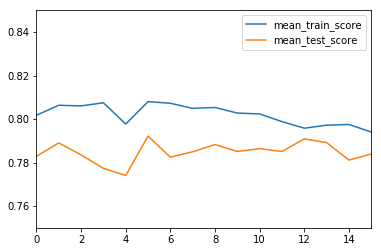

In [13]:
#不同参数组合的准确率图像
results[['mean_train_score','mean_test_score']].plot(ylim=[0.75,0.85])

In [14]:
#模型评估
#评估查看最终选择的结果和交叉验证的结果
print("交叉验证平均准确率：\n", grid_result.best_score_)
print("最好的参数模型：\n", grid_result.best_params_)

交叉验证平均准确率：
 0.7921975544580065
最好的参数模型：
 {'batch_size': 10, 'nb_epoch': 10}


In [15]:
#划分训练集测试集
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(training_padded,train['target'].values,test_size=0.2)

In [16]:
#对比SVM,KNN,多层感知器,朴素贝叶斯，随机森林方法
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn import svm,neighbors,neural_network,naive_bayes,ensemble
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.model_selection import *

model1= svm.SVC()
model1.fit(X_train,y_train)
predict1=model1.predict(X_test)

model2=neighbors.KNeighborsClassifier()
model2.fit(X_train,y_train)

model3=neural_network.MLPClassifier()
model3.fit(X_train,y_train)

model4=naive_bayes.GaussianNB()
model4.fit(X_train,y_train)

model5=ensemble.RandomForestClassifier()
model5.fit(X_train,y_train)

model6=ensemble.GradientBoostingClassifier()
model6.fit(X_train,y_train)


D:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning:

The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.

D:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning:

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.



GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [18]:
#模型评估
print('模型1验证集准确率:',model1.score(X_test, y_test))
print('模型2验证集准确率:',model2.score(X_test, y_test))
print('模型3验证集准确率:',model3.score(X_test, y_test))
print('模型4验证集准确率:',model4.score(X_test, y_test))
print('模型5验证集准确率:',model5.score(X_test, y_test))
print('模型6验证集准确率:',model6.score(X_test, y_test))
#print('模型1测试集AUC:',metrics.roc_auc_score(y_test,predict1))

模型1验证集准确率: 0.6250820748522653
模型2验证集准确率: 0.5843729481286933
模型3验证集准确率: 0.5384110308601444
模型4验证集准确率: 0.4799737360472751
模型5验证集准确率: 0.6323046618516087
模型6验证集准确率: 0.6401838476690742


In [80]:
#test.csv结果预测
test = pd.read_csv("D:/机器学习/NLP/nlp-getting-started/test.csv")
testing_sequences = tokenizer.texts_to_sequences(test.text)
testing_padded = pad_sequences(testing_sequences, maxlen=MAX_LEN, padding='post', truncating='post')
predictions = grid_result.predict(testing_padded)

In [81]:
submission['target'] = (predictions > 0.5).astype(int)
submission

,id,target
0,0,1
1,2,0
2,3,1
3,9,0
4,11,1
...,...,...
3258,10861,1
3259,10865,1
3260,10868,0
3261,10874,0


In [82]:
submission.to_csv("submission.csv", index=False, header=True)